In [1]:
# importing the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch import flatten 
from sklearn.metrics import classification_report #for detailed statistics on classifier
from sklearn.metrics import confusion_matrix
from torchvision.datasets import MNIST #importing the MNIST Dataset already there on torch
from tqdm import tqdm 
from torchvision import transforms #for transforming the training and testing data 
from torch.utils.data import DataLoader #Dataloader loads the data batchwise with shuffling in a hassle free manner
from torch.optim import Adam #Adam for GD
import time 
from torchvision.utils import make_grid #to visualize the kernels the tensors
from torch.autograd import Variable #For the adversarial examples part to find the gradients



In [2]:

class CNN(nn.Module): 
    def __init__(self): 
        super(CNN,self).__init__()
        self.l1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
                                 nn.ReLU(), 
                                 nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))
                                 #https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
                                 #for maxpool one can use a single number for a square windown, but to maintain the uniformity we are giving this way
        
        self.l2 = nn.Sequential(nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1),
                                 nn.ReLU(), 
                                 nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))  
        
        self.fully_connected_l1 = nn.Sequential(nn.Linear(7*7*32, 500),nn.ReLU())
        self.fully_connected_l2 = nn.Linear(500,10)
        self.logsoftmax = nn.LogSoftmax(dim = 1)
        


    def forward(self,x): #defines the structure of the network thus help in performing backprop, it does forward pass
        
        output = self.l1(x.float()) #converting x to float datatype
        output = self.l2(output)
        output = flatten(output,1)
        output = self.fully_connected_l1(output)
        output = self.fully_connected_l2(output)
        
        prediction   = self.logsoftmax(output)
        
        return prediction

In [18]:
#all the constants/parameters 
batch_size = 64
number_of_epochs = 3
learning_rate = 1e-3
beta = 0.01

In [4]:
CURRENT_DIRECTORY = os.getcwd()
FOLDER_NAME = 'mnist'
MODEL_FOLDER = 'model'
save_model = True

In [5]:
#dataloader
if not os.path.exists(os.path.join(CURRENT_DIRECTORY, FOLDER_NAME)):
    os.mkdir(os.path.join(CURRENT_DIRECTORY, FOLDER_NAME))
    to_download = True
if (save_model):
    if not os.path.exists(os.path.join(CURRENT_DIRECTORY, MODEL_FOLDER)):
        os.mkdir(os.path.join(CURRENT_DIRECTORY, MODEL_FOLDER))
PATH_TO_STORE_MODEL = os.path.join(CURRENT_DIRECTORY, MODEL_FOLDER)+'/'

In [6]:

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #checks for gpu else runs in cpu

In [7]:
def Train_model(model,device,Train_Data_Loader,optimizer,loss_function,train_length):

    model.train()

    training_loss = 0
    training_predictions = 0
    
    for (data,label) in tqdm(Train_Data_Loader):
        #sending botht the image array and labels from the dataloader to the model trainer

        (data,label) = (data.to(device),label.to(device))
        #sending the data and the labels into the gpu 

        prediction = model(data) #predict in the forward pass
        loss = loss_function(prediction,label) # calculate the loss 

        training_loss += loss
        training_predictions += (prediction.argmax(1) == label).type(torch.float).sum().item()
        #prediction from the forward pass == labels , then the count of it will increase

    train_accuracy = training_predictions/train_length

    return training_loss , train_accuracy

In [8]:
def Test_model(model,device,Test_Data_Loader,loss_function,test_length):

    model.train()

    testing_loss = 0
    testing_predictions = 0
    
    for (data,label) in tqdm(Test_Data_Loader):
        #sending botht the image array and labels from the dataloader to the model trainer

        (data,label) = (data.to(device),label.to(device))
        #sending the data and the labels into the gpu 

        prediction = model(data) #predict in the forward pass
        loss = loss_function(prediction,label) # calculate the loss 

        testing_loss += loss
        testing_predictions += (prediction.argmax(1) == label).type(torch.float).sum().item()
        #prediction from the forward pass == labels , then the count of it will increase

    test_accuracy = testing_predictions/test_length

    return testing_loss , test_accuracy

In [9]:
app_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    
    #organize the training and test data
    
train_data    = MNIST(CURRENT_DIRECTORY, train = True, download = True, transform = app_transform) #getting training data
test_data     = MNIST(CURRENT_DIRECTORY, train = False, transform = app_transform)

In [10]:
Train_Data_Loader = DataLoader(train_data, batch_size = batch_size, shuffle = True ) 
Test_Data_Loader  = DataLoader(test_data, batch_size = batch_size) 

train_length  = len(Train_Data_Loader.dataset) #no of training examples
test_length   = len(Test_Data_Loader.dataset)  #no of testing cases

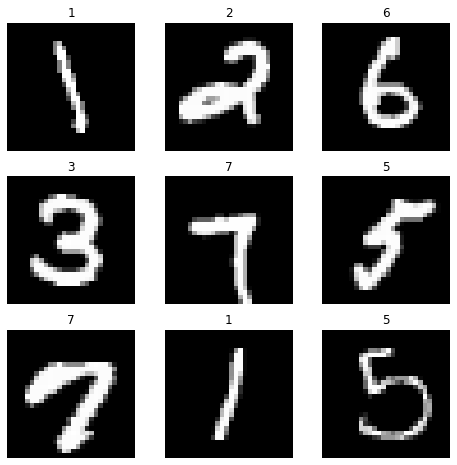

In [11]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(Train_Data_Loader.dataset), size=(1,)).item()
    img, label = Train_Data_Loader.dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [12]:
model = CNN().to(device) 

In [13]:
optimizer = Adam(model.parameters(),lr = learning_rate) #optimizer
    
lossfn    = nn.NLLLoss() #lossFunction

In [14]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
l1.0.weight 	 torch.Size([32, 1, 3, 3])
l1.0.bias 	 torch.Size([32])
l2.0.weight 	 torch.Size([32, 32, 3, 3])
l2.0.bias 	 torch.Size([32])
fully_connected_l1.0.weight 	 torch.Size([500, 1568])
fully_connected_l1.0.bias 	 torch.Size([500])
fully_connected_l2.weight 	 torch.Size([10, 500])
fully_connected_l2.bias 	 torch.Size([10])


In [15]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7]}]


In [16]:
load_model = False

In [19]:
model1=CNN()
criterion1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)

trainingloss_list = []
validationloss_list = []
validationaccuracy_list = []

for epoch in range(number_of_epochs):
  for images, labels in Train_Data_Loader:
      outputs = model1(images.float())
      loss = criterion1(outputs, labels)
      trainingloss_list.append(loss.item())

      optimizer1.zero_grad()
      loss.backward()
      optimizer1.step()

  iteration=0
  tempvalloss=0
  correctval=0    
  
  for images, labels in Test_Data_Loader:
    outputs = model1(images.float())
    loss = criterion1(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    correctval += (predicted == labels).sum().item()
    iteration+=1
    tempvalloss+=loss.item()
            
  validationloss_list.append(tempvalloss/iteration)
  validationaccuracy_list.append(correctval/100)
  print('Epoch',epoch+1,'out of',number_of_epochs,'epochs are over')

KeyboardInterrupt: 